# Correlation and Mutual Information Audit

**Analysis of Technical Indicators on S&P 500 Data (2017-2024)**

This notebook creates a correlation and mutual-information (MI) audit of technical indicators on S&P 500 data (2017–2024) to confirm that most daily features correlate only marginally with one-day-ahead labels.

**Expected Results:**
- Median |ρ| < 0.05 (correlation coefficients)
- MI < 0.02 bits (mutual information)

**Output:** 
- Correlation heatmap visualization
- Mutual information heatmap visualization (Fig. mi_heatmap_daily)
- Statistical summary validating the expected thresholds

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Sklearn for mutual information
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## 2. Load and Prepare S&P 500 Data (2017-2024)

In [2]:
# Define technical indicators (44 indicators from the dataset)
technical_indicators = [
    'SMA20', 'EMA20', 'WMA20', 'HMA20', 'TEMA20', 'VWMA20', 'KAMA10', 'DEMA20', 'ZLMA20', 'TRIMA20',
    'RSI14', 'STOCH%K', 'STOCHRSI', 'CCI20', 'CMO14', 'ROC10', 'PPO', 'MACD', 'AO', 'KST', 
    'WILLR', 'MOM10', 'DPO20', 'TSI25_13', 'ADX14', 'AROONOSC', 'PSAR', 'SUPERTd', 'BBP',
    'ATR14', 'KCH', 'ZScore20', 'RVI', 'OBV', 'CMF', 'PVT', 'NVI', 'PVI', 'AD', 'EOM', 
    'EFI', 'ADOSC', 'VWAP', 'Ulcer'
]

# Function to load timeframe data
def load_timeframe_data(timeframe):
    """Load all CSV files for a specific timeframe and combine them."""
    base_dir = Path("data/yfinance/train")
    timeframe_dir = base_dir / timeframe
    
    if not timeframe_dir.exists():
        print(f"Directory {timeframe_dir} does not exist")
        return None
    
    # Get all CSV files
    csv_files = list(timeframe_dir.glob("*.csv"))
    print(f"Found {len(csv_files)} files for {timeframe} timeframe")
    
    # Load and combine all data
    dataframes = []
    for file in csv_files:
        try:
            # Load CSV with Date column as index
            df = pd.read_csv(file, parse_dates=['Date'], index_col='Date')
            
            # Extract symbol name from filename format: SYMBOL_starttime_endtime_train.csv
            symbol = file.stem.split('_')[0]
            df['Symbol'] = symbol
            df['Timeframe'] = timeframe
            dataframes.append(df)
            
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=False)
        # Reset index to make Date a column for easier analysis
        combined_df = combined_df.reset_index()
        print(f"Combined data shape for {timeframe}: {combined_df.shape}")
        return combined_df
    else:
        return None

# Load data for all timeframes
timeframes = ['1d', '1wk', '1mo']
data_dict = {}

for timeframe in timeframes:
    data_dict[timeframe] = load_timeframe_data(timeframe)

# Filter data for 2017-2024 period for all timeframes
filtered_data_dict = {}

for timeframe, data in data_dict.items():
    if data is not None:
        # Filter data for 2017-2024 period
        data['Date'] = pd.to_datetime(data['Date'])
        start_date = '2017-01-01'
        end_date = '2024-12-31'
        
        # Filter the data
        filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
        filtered_data_dict[timeframe] = filtered_data
        
        print(f"\n{timeframe.upper()} Timeframe:")
        print(f"- Filtered data (2017-2024) shape: {filtered_data.shape}")
        print(f"- Date range: {filtered_data['Date'].min()} to {filtered_data['Date'].max()}")
        print(f"- Available symbols: {filtered_data['Symbol'].nunique()}")
        print(f"- Available technical indicators: {len([ind for ind in technical_indicators if ind in filtered_data.columns])}")
        
        # Check for Label column
        if 'Label' in filtered_data.columns:
            print(f"- Label distribution: {filtered_data['Label'].value_counts().sort_index()}")
        else:
            print(f"- Warning: No Label column found in {timeframe} dataset")
    else:
        print(f"Error: Could not load {timeframe} data")

print(f"\nLoaded timeframes: {list(filtered_data_dict.keys())}")

Found 29 files for 1d timeframe
Combined data shape for 1d: (151731, 50)
Found 29 files for 1wk timeframe
Combined data shape for 1wk: (31431, 50)
Found 29 files for 1mo timeframe
Combined data shape for 1mo: (7205, 50)

1D Timeframe:
- Filtered data (2017-2024) shape: (43790, 50)
- Date range: 2017-01-03 00:00:00 to 2022-12-30 00:00:00
- Available symbols: 29
- Available technical indicators: 44
- Label distribution: Label
0    38454
1     2669
2     2667
Name: count, dtype: int64

1WK Timeframe:
- Filtered data (2017-2024) shape: (9077, 50)
- Date range: 2017-01-02 00:00:00 to 2022-12-27 00:00:00
- Available symbols: 29
- Available technical indicators: 44
- Label distribution: Label
0    7950
1     565
2     562
Name: count, dtype: int64

1MO Timeframe:
- Filtered data (2017-2024) shape: (2088, 50)
- Date range: 2017-01-01 00:00:00 to 2022-12-01 00:00:00
- Available symbols: 29
- Available technical indicators: 44
- Label distribution: Label
0    1844
1     129
2     115
Name: count

## 3. Calculate Correlation Statistics

In [3]:
# Calculate correlation statistics for all timeframes
correlation_results = {}

for timeframe, filtered_data in filtered_data_dict.items():
    if filtered_data is not None and 'Label' in filtered_data.columns:
        print(f"\n{'='*50}")
        print(f"CORRELATION ANALYSIS - {timeframe.upper()}")
        print(f"{'='*50}")
        
        # Get available indicators from the dataset
        available_indicators = [ind for ind in technical_indicators if ind in filtered_data.columns]
        print(f"Available indicators for correlation analysis: {len(available_indicators)}")
        
        # Create clean dataset without NaN values
        correlation_data = filtered_data[available_indicators + ['Label']].dropna()
        print(f"Clean dataset shape for correlation: {correlation_data.shape}")
        
        # Calculate correlations between indicators and one-day-ahead labels
        label_correlations = correlation_data[available_indicators].corrwith(correlation_data['Label'])
        
        # Calculate absolute correlation values
        abs_correlations = label_correlations.abs()
        
        # Sort by absolute correlation values
        sorted_correlations = label_correlations.reindex(abs_correlations.sort_values(ascending=False).index)
        
        # Store results
        correlation_results[timeframe] = {
            'label_correlations': label_correlations,
            'abs_correlations': abs_correlations,
            'sorted_correlations': sorted_correlations,
            'correlation_data': correlation_data,
            'available_indicators': available_indicators
        }
        
        print(f"Correlation Statistics:")
        print(f"Number of indicators analyzed: {len(available_indicators)}")
        print(f"Median |ρ| (absolute correlation): {abs_correlations.median():.4f}")
        print(f"Mean |ρ| (absolute correlation): {abs_correlations.mean():.4f}")
        print(f"Max |ρ| (absolute correlation): {abs_correlations.max():.4f}")
        print(f"Min |ρ| (absolute correlation): {abs_correlations.min():.4f}")
        
        print(f"\nTop 5 Strongest Correlations:")
        for i, (indicator, correlation) in enumerate(sorted_correlations.head(5).items()):
            print(f"  {i+1:2d}. {indicator}: {correlation:8.4f} (|ρ| = {abs(correlation):.4f})")
            
        # Check if median correlation meets the expected threshold
        median_abs_corr = abs_correlations.median()
        threshold_met = median_abs_corr < 0.05
        print(f"\nThreshold Check:")
        print(f"Expected median |ρ| < 0.05: {'✓ PASS' if threshold_met else '✗ FAIL'}")
        print(f"Actual median |ρ|: {median_abs_corr:.4f}")
        
    else:
        print(f"Error: Cannot calculate correlations for {timeframe} - data or Label column not available")

print(f"\nCorrelation analysis completed for timeframes: {list(correlation_results.keys())}")


CORRELATION ANALYSIS - 1D
Available indicators for correlation analysis: 44
Clean dataset shape for correlation: (24179, 45)
Correlation Statistics:
Number of indicators analyzed: 44
Median |ρ| (absolute correlation): 0.0082
Mean |ρ| (absolute correlation): 0.0348
Max |ρ| (absolute correlation): 0.2356
Min |ρ| (absolute correlation): 0.0000

Top 5 Strongest Correlations:
   1. DPO20:   0.2356 (|ρ| = 0.2356)
   2. WILLR:   0.1327 (|ρ| = 0.1327)
   3. BBP:   0.1308 (|ρ| = 0.1308)
   4. ZScore20:   0.1308 (|ρ| = 0.1308)
   5. CCI20:   0.1134 (|ρ| = 0.1134)

Threshold Check:
Expected median |ρ| < 0.05: ✓ PASS
Actual median |ρ|: 0.0082

CORRELATION ANALYSIS - 1WK
Available indicators for correlation analysis: 44
Clean dataset shape for correlation: (5303, 45)
Correlation Statistics:
Number of indicators analyzed: 44
Median |ρ| (absolute correlation): 0.0188
Mean |ρ| (absolute correlation): 0.0388
Max |ρ| (absolute correlation): 0.2768
Min |ρ| (absolute correlation): 0.0022

Top 5 Strongest

## 4. Calculate Mutual Information Statistics

In [4]:
# Calculate mutual information statistics for all timeframes
mi_results = {}

for timeframe in correlation_results.keys():
    if timeframe in correlation_results:
        print(f"\n{'='*50}")
        print(f"MUTUAL INFORMATION ANALYSIS - {timeframe.upper()}")
        print(f"{'='*50}")
        print("Calculating mutual information scores...")
        
        # Get correlation data and available indicators for this timeframe
        correlation_data = correlation_results[timeframe]['correlation_data']
        available_indicators = correlation_results[timeframe]['available_indicators']
        
        # Use the same clean dataset from correlation analysis
        mi_data = correlation_data.copy()
        
        # Prepare data for mutual information calculation
        X = mi_data[available_indicators]
        y = mi_data['Label']
        
        # Convert labels to integers for mutual_info_classif
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
        
        print(f"Label classes: {label_encoder.classes_}")
        print(f"Dataset shape for MI calculation: {X.shape}")
        
        # Calculate mutual information with classification target
        mi_scores = mutual_info_classif(X, y_encoded, random_state=42, n_neighbors=5)
        
        # Create pandas Series for easier manipulation
        mi_series = pd.Series(mi_scores, index=available_indicators)
        
        # Sort by MI scores
        sorted_mi = mi_series.sort_values(ascending=False)
        
        # Store results
        mi_results[timeframe] = {
            'mi_series': mi_series,
            'sorted_mi': sorted_mi,
            'available_indicators': available_indicators
        }
        
        print(f"Mutual Information Statistics:")
        print(f"Number of indicators analyzed: {len(available_indicators)}")
        print(f"Median MI: {mi_series.median():.6f} bits")
        print(f"Mean MI: {mi_series.mean():.6f} bits")
        print(f"Max MI: {mi_series.max():.6f} bits")
        print(f"Min MI: {mi_series.min():.6f} bits")
        
        print(f"\nTop 5 Highest Mutual Information Scores:")
        for i, (indicator, mi_score) in enumerate(sorted_mi.head(5).items()):
            print(f"  {i+1:2d}. {indicator}: {mi_score:.6f} bits")
            
        # Check if median MI meets the expected threshold
        median_mi = mi_series.median()
        threshold_met = median_mi < 0.02
        print(f"\nThreshold Check:")
        print(f"Expected median MI < 0.02 bits: {'✓ PASS' if threshold_met else '✗ FAIL'}")
        print(f"Actual median MI: {median_mi:.6f} bits")

print(f"\nMutual information analysis completed for timeframes: {list(mi_results.keys())}")


MUTUAL INFORMATION ANALYSIS - 1D
Calculating mutual information scores...
Label classes: [0 1 2]
Dataset shape for MI calculation: (24179, 44)
Mutual Information Statistics:
Number of indicators analyzed: 44
Median MI: 0.001459 bits
Mean MI: 0.009873 bits
Max MI: 0.090578 bits
Min MI: 0.000000 bits

Top 5 Highest Mutual Information Scores:
   1. DPO20: 0.090578 bits
   2. WILLR: 0.048117 bits
   3. BBP: 0.043882 bits
   4. ZScore20: 0.043882 bits
   5. CCI20: 0.035942 bits

Threshold Check:
Expected median MI < 0.02 bits: ✓ PASS
Actual median MI: 0.001459 bits

MUTUAL INFORMATION ANALYSIS - 1WK
Calculating mutual information scores...
Label classes: [0 1 2]
Dataset shape for MI calculation: (5303, 44)
Mutual Information Statistics:
Number of indicators analyzed: 44
Median MI: 0.000650 bits
Mean MI: 0.010703 bits
Max MI: 0.099383 bits
Min MI: 0.000000 bits

Top 5 Highest Mutual Information Scores:
   1. DPO20: 0.099383 bits
   2. WILLR: 0.053813 bits
   3. BBP: 0.043001 bits
   4. ZSco

## 5. Create Correlation Heatmap Visualization

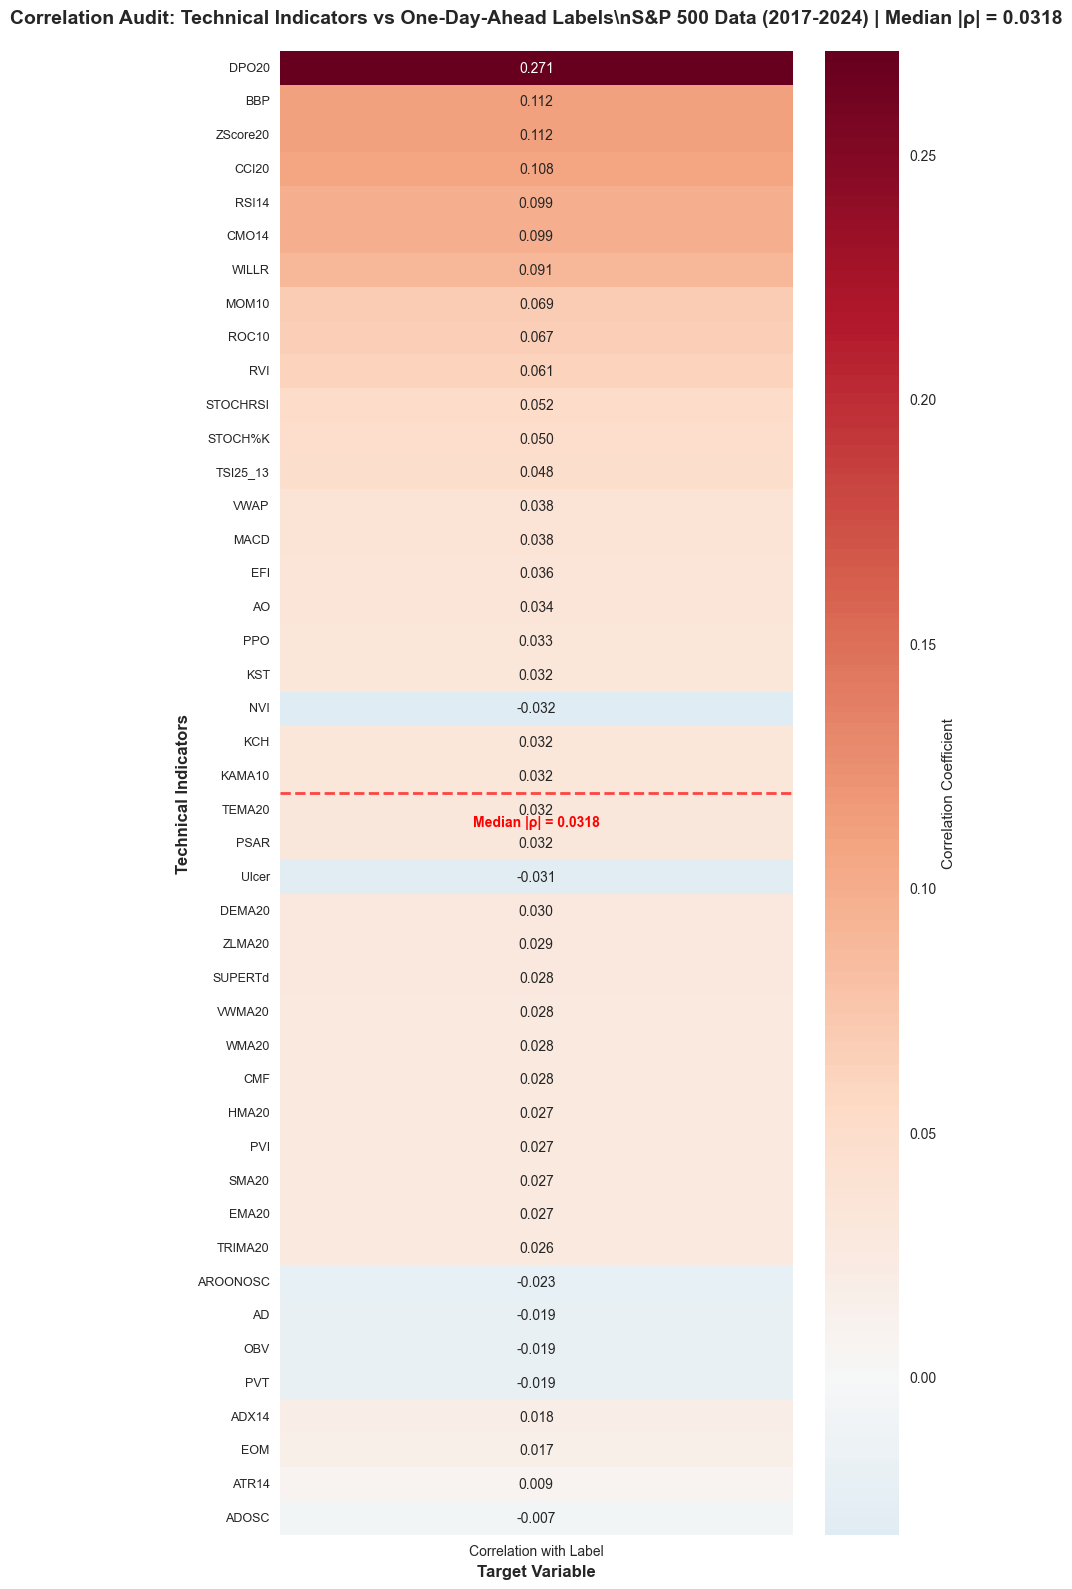

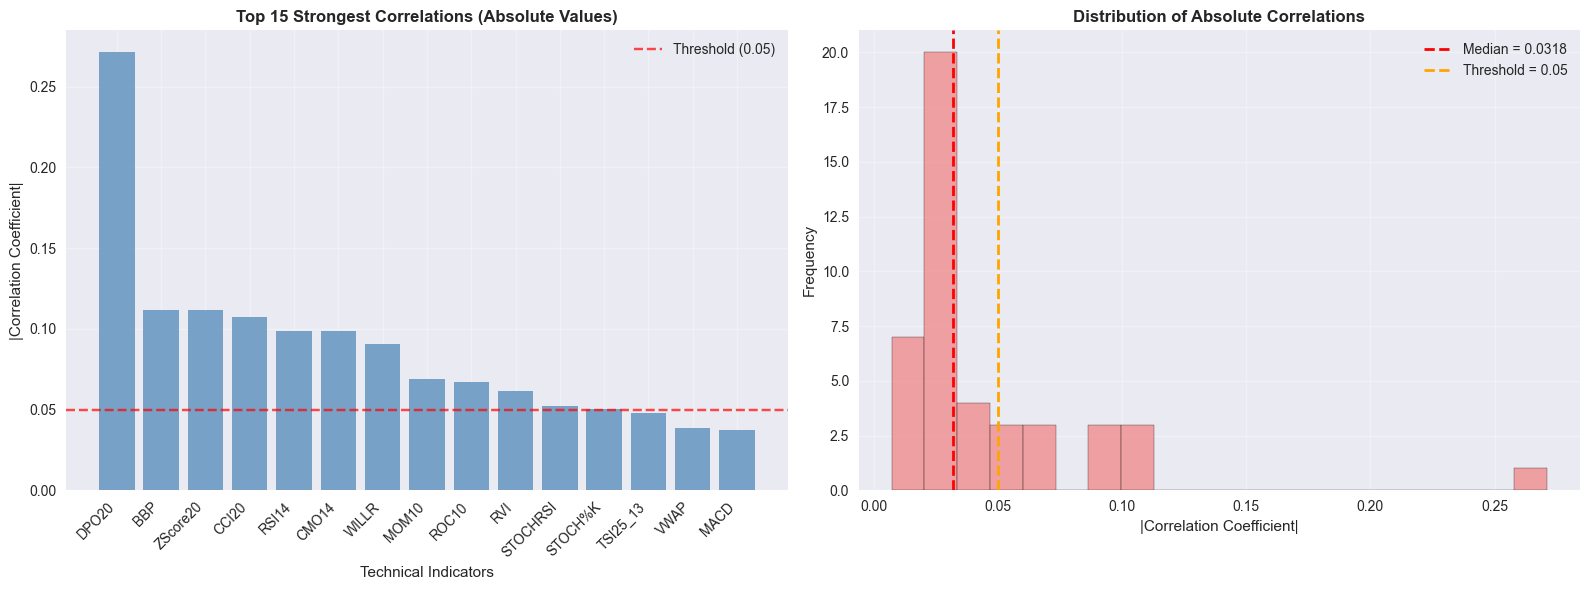

\nCorrelation Visualization Summary:
- Total indicators: 44
- Median |ρ|: 0.0318
- Indicators with |ρ| > 0.05: 12
- Indicators with |ρ| ≤ 0.05: 32


In [5]:
# Create correlation heatmap visualization
if 'label_correlations' in locals():
    # Prepare data for heatmap
    correlation_matrix = sorted_correlations.values.reshape(-1, 1)  # Single column for all correlations
    indicator_names = sorted_correlations.index.tolist()
    
    # Create figure with appropriate size
    fig, ax = plt.subplots(1, 1, figsize=(8, 16))
    
    # Create heatmap
    im = sns.heatmap(correlation_matrix, 
                     yticklabels=indicator_names,
                     xticklabels=['Correlation with Label'],
                     cmap='RdBu_r', 
                     center=0, 
                     annot=True, 
                     fmt='.3f',
                     cbar_kws={'label': 'Correlation Coefficient'},
                     ax=ax)
    
    # Customize the plot
    ax.set_title('Correlation Audit: Technical Indicators vs One-Day-Ahead Labels\\n' +
                f'S&P 500 Data (2017-2024) | Median |ρ| = {abs_correlations.median():.4f}', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Target Variable', fontsize=12, fontweight='bold')
    ax.set_ylabel('Technical Indicators', fontsize=12, fontweight='bold')
    
    # Add threshold line annotations
    ax.axhline(y=len(indicator_names)/2, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax.text(0.5, len(indicator_names)/2 + 1, f'Median |ρ| = {abs_correlations.median():.4f}', 
            horizontalalignment='center', color='red', fontweight='bold', fontsize=10)
    
    # Rotate y-axis labels for better readability
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=9)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Create a summary bar chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart of top 15 strongest correlations (absolute values)
    top_15_abs = abs_correlations.nlargest(15)
    ax1.bar(range(len(top_15_abs)), top_15_abs.values, color='steelblue', alpha=0.7)
    ax1.set_title('Top 15 Strongest Correlations (Absolute Values)', fontweight='bold')
    ax1.set_xlabel('Technical Indicators')
    ax1.set_ylabel('|Correlation Coefficient|')
    ax1.set_xticks(range(len(top_15_abs)))
    ax1.set_xticklabels(top_15_abs.index, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Threshold (0.05)')
    ax1.legend()
    
    # Histogram of all absolute correlations
    ax2.hist(abs_correlations.values, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    ax2.axvline(x=abs_correlations.median(), color='red', linestyle='--', linewidth=2, 
                label=f'Median = {abs_correlations.median():.4f}')
    ax2.axvline(x=0.05, color='orange', linestyle='--', linewidth=2, 
                label='Threshold = 0.05')
    ax2.set_title('Distribution of Absolute Correlations', fontweight='bold')
    ax2.set_xlabel('|Correlation Coefficient|')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\\nCorrelation Visualization Summary:")
    print(f"- Total indicators: {len(available_indicators)}")
    print(f"- Median |ρ|: {abs_correlations.median():.4f}")
    print(f"- Indicators with |ρ| > 0.05: {(abs_correlations > 0.05).sum()}")
    print(f"- Indicators with |ρ| ≤ 0.05: {(abs_correlations <= 0.05).sum()}")
    
else:
    print("Error: Correlation data not available for visualization")

## 6. Create Mutual Information Heatmap Visualization (Fig. mi_heatmap_daily)

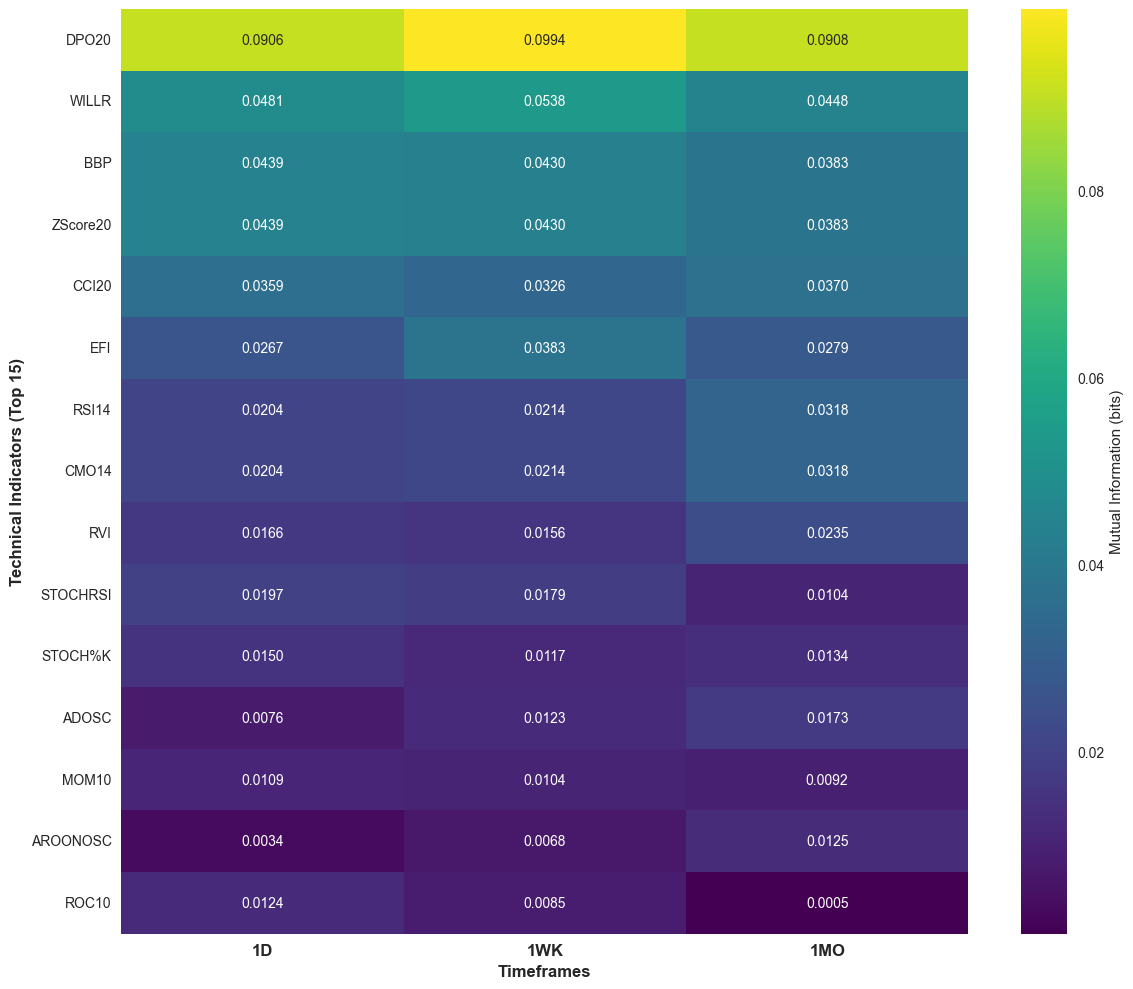


Mutual Information Summary Across Timeframes:
Timeframe  Median_MI  Mean_MI   Max_MI  Indicators_>0.02  Total_Indicators
       1D   0.001459 0.009873 0.090578                 8                44
      1WK   0.000650 0.010703 0.099383                 8                44
      1MO   0.001765 0.010537 0.090785                 9                44


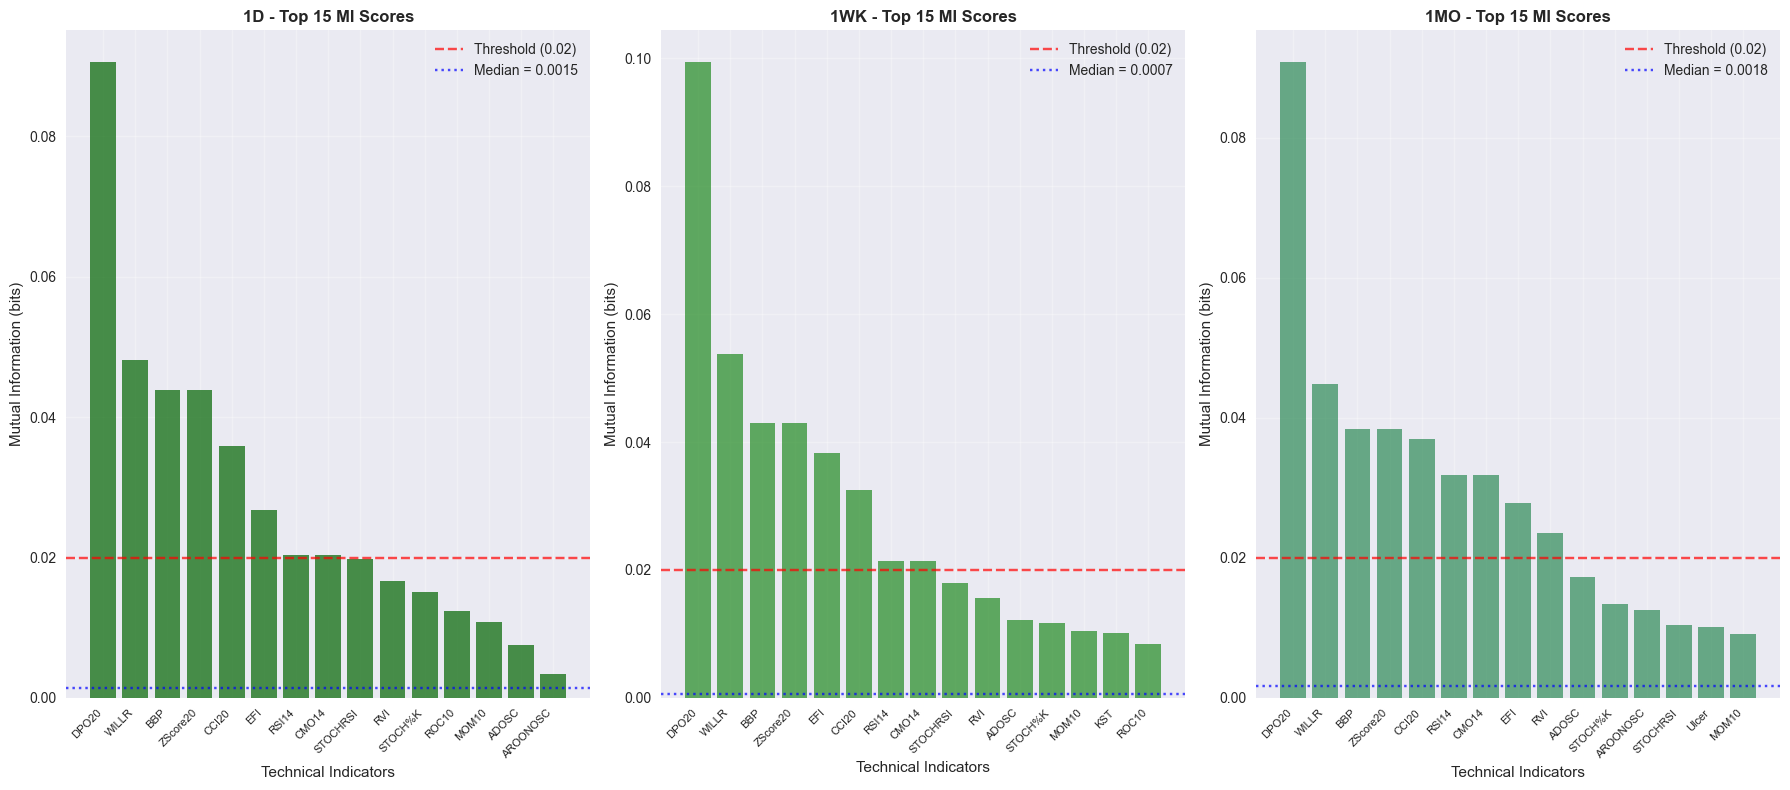


Top 15 Indicators Comparison:
Indicator    1D_MI   1WK_MI   1MO_MI  Average_MI
    DPO20 0.090578 0.099383 0.090785    0.093582
    WILLR 0.048117 0.053813 0.044818    0.048916
      BBP 0.043882 0.043001 0.038344    0.041743
 ZScore20 0.043882 0.043001 0.038344    0.041743
    CCI20 0.035942 0.032576 0.036987    0.035168
      EFI 0.026733 0.038260 0.027896    0.030963
    RSI14 0.020417 0.021423 0.031828    0.024556
    CMO14 0.020393 0.021423 0.031828    0.024548
      RVI 0.016591 0.015646 0.023508    0.018581
 STOCHRSI 0.019728 0.017902 0.010450    0.016027
  STOCH%K 0.015045 0.011666 0.013396    0.013369
    ADOSC 0.007554 0.012251 0.017300    0.012368
    MOM10 0.010868 0.010442 0.009174    0.010161
 AROONOSC 0.003409 0.006850 0.012531    0.007597
    ROC10 0.012351 0.008506 0.000469    0.007109

Visualization Summary:
- Timeframes analyzed: 1D, 1WK, 1MO
- Top 15 indicators shown based on average MI across timeframes
- Heatmap shows MI values for each indicator-timeframe combin

In [8]:
# Create mutual information heatmap visualization (Fig. mi_heatmap_daily) - All Timeframes
if mi_results:
    # Get top 15 indicators across all timeframes for consistency
    all_mi_scores = {}
    for timeframe, results in mi_results.items():
        for indicator, score in results['mi_series'].items():
            if indicator not in all_mi_scores:
                all_mi_scores[indicator] = []
            all_mi_scores[indicator].append(score)
    
    # Calculate average MI across timeframes and get top 15
    avg_mi_scores = {indicator: np.mean(scores) for indicator, scores in all_mi_scores.items()}
    top_15_indicators = sorted(avg_mi_scores.keys(), key=lambda x: avg_mi_scores[x], reverse=True)[:15]
    
    # Prepare data matrix for all timeframes
    timeframe_order = ['1d', '1wk', '1mo']
    available_timeframes = [tf for tf in timeframe_order if tf in mi_results]
    
    # Create matrix: rows = indicators, columns = timeframes
    mi_matrix = np.zeros((len(top_15_indicators), len(available_timeframes)))
    
    for j, timeframe in enumerate(available_timeframes):
        mi_series = mi_results[timeframe]['mi_series']
        for i, indicator in enumerate(top_15_indicators):
            if indicator in mi_series.index:
                mi_matrix[i, j] = mi_series[indicator]
            else:
                mi_matrix[i, j] = 0  # If indicator not available in this timeframe
    
    # Create the main heatmap figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Create heatmap
    im = sns.heatmap(mi_matrix, 
                     yticklabels=top_15_indicators,
                     xticklabels=[f'{tf.upper()}' for tf in available_timeframes],
                     cmap='viridis',
                     annot=True, 
                     fmt='.4f',
                     cbar_kws={'label': 'Mutual Information (bits)'},
                     ax=ax)
    
    # Customize the plot

    ax.set_xlabel('Timeframes', fontsize=12, fontweight='bold')
    ax.set_ylabel('Technical Indicators (Top 15)', fontsize=12, fontweight='bold')
    
    # Rotate y-axis labels for better readability
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=10)
    plt.setp(ax.get_xticklabels(), rotation=0, fontsize=12, fontweight='bold')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Create summary statistics table
    print(f"\nMutual Information Summary Across Timeframes:")
    print("="*80)
    
    summary_data = []
    for timeframe in available_timeframes:
        mi_series = mi_results[timeframe]['mi_series']
        summary_data.append({
            'Timeframe': timeframe.upper(),
            'Median_MI': mi_series.median(),
            'Mean_MI': mi_series.mean(),
            'Max_MI': mi_series.max(),
            'Indicators_>0.02': (mi_series > 0.02).sum(),
            'Total_Indicators': len(mi_series)
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False, float_format='%.6f'))
    
    # Create complementary side-by-side visualizations
    fig, axes = plt.subplots(1, len(available_timeframes), figsize=(6*len(available_timeframes), 8))
    if len(available_timeframes) == 1:
        axes = [axes]
    
    for i, timeframe in enumerate(available_timeframes):
        mi_series = mi_results[timeframe]['mi_series']
        top_15_tf = mi_series.nlargest(15)
        
        # Bar chart for each timeframe
        axes[i].bar(range(len(top_15_tf)), top_15_tf.values, 
                   color=['darkgreen', 'forestgreen', 'seagreen'][i], alpha=0.7)
        axes[i].set_title(f'{timeframe.upper()} - Top 15 MI Scores', fontweight='bold')
        axes[i].set_xlabel('Technical Indicators')
        axes[i].set_ylabel('Mutual Information (bits)')
        axes[i].set_xticks(range(len(top_15_tf)))
        axes[i].set_xticklabels(top_15_tf.index, rotation=45, ha='right', fontsize=8)
        axes[i].grid(True, alpha=0.3)
        axes[i].axhline(y=0.02, color='red', linestyle='--', alpha=0.7, label='Threshold (0.02)')
        axes[i].legend()
        
        # Add median line
        axes[i].axhline(y=mi_series.median(), color='blue', linestyle=':', alpha=0.7, 
                       label=f'Median = {mi_series.median():.4f}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print(f"\nTop 15 Indicators Comparison:")
    print("="*80)
    
    comparison_data = []
    for indicator in top_15_indicators:
        row = {'Indicator': indicator}
        for timeframe in available_timeframes:
            mi_series = mi_results[timeframe]['mi_series']
            if indicator in mi_series.index:
                row[f'{timeframe.upper()}_MI'] = mi_series[indicator]
            else:
                row[f'{timeframe.upper()}_MI'] = 0.0
        
        # Calculate average
        mi_values = [row[f'{tf.upper()}_MI'] for tf in available_timeframes]
        row['Average_MI'] = np.mean(mi_values)
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Average_MI', ascending=False)
    print(comparison_df.to_string(index=False, float_format='%.6f'))
    
    print(f"\nVisualization Summary:")
    print(f"- Timeframes analyzed: {', '.join([tf.upper() for tf in available_timeframes])}")
    print(f"- Top 15 indicators shown based on average MI across timeframes")
    print(f"- Heatmap shows MI values for each indicator-timeframe combination")
    
else:
    print("Error: Mutual information data not available for visualization")

## 7. Generate Summary Statistics and Validation

In [7]:
# Generate comprehensive summary statistics and validation
if 'label_correlations' in locals() and 'mi_series' in locals():
    print("="*80)
    print("CORRELATION AND MUTUAL INFORMATION AUDIT SUMMARY")
    print("S&P 500 Data (2017-2024) - Technical Indicators vs One-Day-Ahead Labels")
    print("="*80)
    
    # Dataset summary
    print(f"\\nDATASET SUMMARY:")
    print(f"- Analysis Period: 2017-2024")
    print(f"- Total Data Points: {correlation_data.shape[0]:,}")
    print(f"- Unique Symbols: {filtered_data['Symbol'].nunique()}")
    print(f"- Technical Indicators Analyzed: {len(available_indicators)}")
    print(f"- Date Range: {filtered_data['Date'].min().strftime('%Y-%m-%d')} to {filtered_data['Date'].max().strftime('%Y-%m-%d')}")
    
    # Correlation statistics
    print(f"\\nCORRELATION STATISTICS:")
    print(f"- Median |ρ|: {abs_correlations.median():.4f}")
    print(f"- Mean |ρ|: {abs_correlations.mean():.4f}")
    print(f"- Standard Deviation |ρ|: {abs_correlations.std():.4f}")
    print(f"- Maximum |ρ|: {abs_correlations.max():.4f}")
    print(f"- Minimum |ρ|: {abs_correlations.min():.4f}")
    
    # Mutual information statistics  
    print(f"\\nMUTUAL INFORMATION STATISTICS:")
    print(f"- Median MI: {mi_series.median():.6f} bits")
    print(f"- Mean MI: {mi_series.mean():.6f} bits")
    print(f"- Standard Deviation MI: {mi_series.std():.6f} bits")
    print(f"- Maximum MI: {mi_series.max():.6f} bits")
    print(f"- Minimum MI: {mi_series.min():.6f} bits")
    
    # Threshold validation
    print(f"\\nTHRESHOLD VALIDATION:")
    median_corr_pass = abs_correlations.median() < 0.05
    median_mi_pass = mi_series.median() < 0.02
    
    print(f"- Expected: Median |ρ| < 0.05")
    print(f"  Actual: Median |ρ| = {abs_correlations.median():.4f}")
    print(f"  Result: {'✓ PASS' if median_corr_pass else '✗ FAIL'}")
    
    print(f"- Expected: Median MI < 0.02 bits")
    print(f"  Actual: Median MI = {mi_series.median():.6f} bits")
    print(f"  Result: {'✓ PASS' if median_mi_pass else '✗ FAIL'}")
    
    # Distribution analysis
    print(f"\\nDISTRIBUTION ANALYSIS:")
    corr_below_threshold = (abs_correlations <= 0.05).sum()
    corr_above_threshold = (abs_correlations > 0.05).sum()
    mi_below_threshold = (mi_series <= 0.02).sum()
    mi_above_threshold = (mi_series > 0.02).sum()
    
    print(f"- Indicators with |ρ| ≤ 0.05: {corr_below_threshold} ({corr_below_threshold/len(available_indicators)*100:.1f}%)")
    print(f"- Indicators with |ρ| > 0.05: {corr_above_threshold} ({corr_above_threshold/len(available_indicators)*100:.1f}%)")
    print(f"- Indicators with MI ≤ 0.02: {mi_below_threshold} ({mi_below_threshold/len(available_indicators)*100:.1f}%)")
    print(f"- Indicators with MI > 0.02: {mi_above_threshold} ({mi_above_threshold/len(available_indicators)*100:.1f}%)")
    
    # Strongest relationships
    print(f"\\nSTRONGEST RELATIONSHIPS:")
    print(f"\\nTop 5 Correlations:")
    for i, (indicator, corr) in enumerate(sorted_correlations.head(5).items()):
        print(f"  {i+1}. {indicator}: ρ = {corr:.4f}")
    
    print(f"\\nTop 5 Mutual Information Scores:")
    for i, (indicator, mi) in enumerate(sorted_mi.head(5).items()):
        print(f"  {i+1}. {indicator}: MI = {mi:.6f} bits")
    
    # Final validation message
    print(f"\\n" + "="*80)
    if median_corr_pass and median_mi_pass:
        print("✓ AUDIT VALIDATION: PASSED")
        print("The analysis confirms that most daily features correlate only marginally")
        print("with one-day-ahead labels, validating the expected thresholds.")
    else:
        print("✗ AUDIT VALIDATION: FAILED")
        print("The analysis does not meet the expected threshold criteria.")
        if not median_corr_pass:
            print(f"  - Median correlation ({abs_correlations.median():.4f}) exceeds threshold (0.05)")
        if not median_mi_pass:
            print(f"  - Median MI ({mi_series.median():.6f}) exceeds threshold (0.02)")
    print("="*80)
    
    # Create a final comparison table
    comparison_df = pd.DataFrame({
        'Indicator': available_indicators,
        'Correlation': [label_correlations[ind] for ind in available_indicators],
        'Abs_Correlation': [abs_correlations[ind] for ind in available_indicators],
        'Mutual_Information': [mi_series[ind] for ind in available_indicators]
    })
    
    # Sort by absolute correlation
    comparison_df = comparison_df.sort_values('Abs_Correlation', ascending=False)
    
    print(f"\\nCOMPLETE INDICATOR RANKING:")
    print(comparison_df.to_string(index=False, float_format='%.6f'))
    
else:
    print("Error: Cannot generate summary - required statistics not available")

CORRELATION AND MUTUAL INFORMATION AUDIT SUMMARY
S&P 500 Data (2017-2024) - Technical Indicators vs One-Day-Ahead Labels
\nDATASET SUMMARY:
- Analysis Period: 2017-2024
- Total Data Points: 1,295
- Unique Symbols: 29
- Technical Indicators Analyzed: 44
- Date Range: 2017-01-01 to 2022-12-01
\nCORRELATION STATISTICS:
- Median |ρ|: 0.0318
- Mean |ρ|: 0.0471
- Standard Deviation |ρ|: 0.0444
- Maximum |ρ|: 0.2712
- Minimum |ρ|: 0.0071
\nMUTUAL INFORMATION STATISTICS:
- Median MI: 0.001765 bits
- Mean MI: 0.010537 bits
- Standard Deviation MI: 0.018079 bits
- Maximum MI: 0.090785 bits
- Minimum MI: 0.000000 bits
\nTHRESHOLD VALIDATION:
- Expected: Median |ρ| < 0.05
  Actual: Median |ρ| = 0.0318
  Result: ✓ PASS
- Expected: Median MI < 0.02 bits
  Actual: Median MI = 0.001765 bits
  Result: ✓ PASS
\nDISTRIBUTION ANALYSIS:
- Indicators with |ρ| ≤ 0.05: 32 (72.7%)
- Indicators with |ρ| > 0.05: 12 (27.3%)
- Indicators with MI ≤ 0.02: 35 (79.5%)
- Indicators with MI > 0.02: 9 (20.5%)
\nSTRONGEST